# Diabetes Prediction - Feature Engineering & Preprocessing Pipeline

**Continuation from EDA (Notebook 1)**:  
[`1_eda.ipynb`](./1_eda.ipynb) | *Key conclusions: Median imputation for zeros, interaction terms, clinical binning*

## Objectives
1. **Split dat into Train & Test Sets**

2. **Replace 0 with NaN**
   - A value of 0 for specific features likely indicate missing values
   - values include: glucose, blood pressure, skin thickness, insulin, and BMI
   - 0s for these features will be converted to NaN values for imputation

4. **Implement EDA-Driven Processing**:
   - Handle biologically impossible zeros via median imputation
   - Create interaction/polynomial features justified by physiological relationships
   - Bin features using clinically validated thresholds

5. **Build Reproducible Pipeline**:
   - Modular transformers for each preprocessing step
   - Column-aware transformations to maintain interpretability
   - Output pandas DataFrames at each stage for validation

6. **Prepare for Model Comparison**:
   - Ensure identical preprocessing across all models
   - Generate datasets suitable for both linear (logistic regression) and tree-based (XGBoost) algorithms

## Pipeline Architecture
```mermaid
graph LR
    A[Raw Data] --> B[Impute Zeros]
    B --> C[Add Interactions]
    C --> D[Bin Features]
    D --> E[Encode Bins]
    E --> F[Log Transform]
    F --> G[Scale Features]
    G --> H[Model-Ready Data]


# Libraries & Paths

In [1]:
import sys
import os
from pathlib import Path

# add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# import modulues 
from src.features.interactions import AddInteractionFeatures
from src.features.binning import BinFeatures
from src.features.pipeline import create_preprocessor_pipeline

import pandas as pd
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import set_config
from IPython.display import display
import os
import pickle
from joblib import dump

In [2]:
# verify imports
print('Classes loaded successfully!')
print('AddInteractionFeatures:', AddInteractionFeatures)
print('BinFeatures:', BinFeatures)
print('Pipeline function:', create_preprocessor_pipeline)

Classes loaded successfully!
AddInteractionFeatures: <class 'src.features.interactions.AddInteractionFeatures'>
BinFeatures: <class 'src.features.binning.BinFeatures'>
Pipeline function: <function create_preprocessor_pipeline at 0x000002450E9D94E0>


# Load the data

In [3]:
data_path = project_root / "data" / "raw" / "diabetes.csv"
df = pd.read_csv(data_path)

In [4]:
print(f'df shape: {df.shape}')

df shape: (768, 9)


# Split the data into train & test sets

In [5]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [6]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

print(f'\nX_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (614, 8)
y_train shape: (614,)

X_test shape: (154, 8)
y_test shape: (154,)


# Data imbalance of the train and test sets

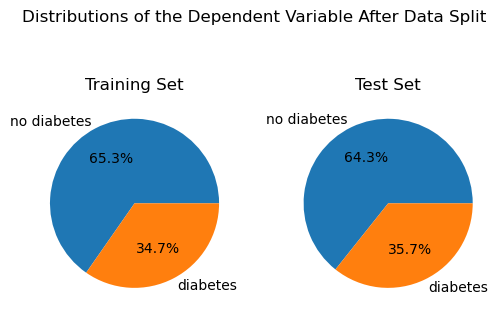

In [7]:
# I will determine if the data split yields sets with similar distributions of the outcome variable

fig,ax = plt.subplots(1,2, figsize=(6,4))

y_train.value_counts().plot.pie(ax=ax[0], labels=['no diabetes', 'diabetes'], autopct='%1.1f%%')
ax[0].set_title('Training Set')
ax[0].set_ylabel('')

y_test.value_counts().plot.pie(ax=ax[1], labels=['no diabetes', 'diabetes'], autopct='%1.1f%%')
ax[1].set_title('Test Set')
ax[1].set_ylabel('')

plt.suptitle('Distributions of the Dependent Variable After Data Split')
plt.show()

Both datasets (train and test) have very similar distributions with regard to the dependent (Outcome) variable.  

# Value == 0 --> NaN for specific features

As determined in notebook 1_eda, a value of 0 for some specific features is not biologically possible.  So, values == 0 for these features will be converted to NaN prior to imputation by the preprocessor. 

In [8]:
# first verify that there are no NaNs for any features:

print(f'X_train NaN count: \n{X_train.isna().sum()}')
print(f'\nX_test NaN count: \n{X_test.isna().sum()}')

X_train NaN count: 
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

X_test NaN count: 
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


In [9]:
features_to_impute = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# replace 0s with NaNs for features to impute
X_train[features_to_impute] = X_train[features_to_impute].replace(0, np.nan)
X_test[features_to_impute] = X_test[features_to_impute].replace(0, np.nan)

In [10]:
# inspect replacement

print(f'X_train NaN count after replacement: \n{X_train.isna().sum()}')
print(f'\nX_test NaN count after replacement: \n{X_test.isna().sum()}')

X_train NaN count after replacement: 
Pregnancies                   0
Glucose                       5
BloodPressure                24
SkinThickness               176
Insulin                     290
BMI                           7
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

X_test NaN count after replacement: 
Pregnancies                  0
Glucose                      0
BloodPressure               11
SkinThickness               51
Insulin                     84
BMI                          4
DiabetesPedigreeFunction     0
Age                          0
dtype: int64


# Test the pipeline

## Instantiate the pipeline

In [11]:
set_config(display='diagram')
preprocessor = create_preprocessor_pipeline()

display(preprocessor)

Pipeline(steps=[('impute',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='median'),
                                                  ['Glucose', 'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI'])],
                                   verbose_feature_names_out=False)),
                ('add_interaction', AddInteractionFeatures()),
                ('bin_features', BinFeatures()),
                ('encode',
                 ColumnTransf...
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['Glucose', 'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI', 'GlucoseXAge',
                                                   'GlucoseXBMI', 'InsulinXBMI',
                                                   'GlucoseInsulinRatio',
                                                   'BMISqrd', 'GlucoseSqrd',
                                                   'AgeSqrd', 'Pregnancies',
                                                   'DiabetesPedigreeFunction',
                                                   'Age'])],
                                   verbose_feature_names_out=False))])

## Check output 

### after each preprocessing step

In [12]:
# Step 0: before any preprocessing
print(f'Before preprocessing:\n{X_train[:5]}')

preprocessor.fit(X_train)

# Step 1: Imputation
imputedData = preprocessor.named_steps['impute'].transform(X_train)
print(f'\nAfter Imputation:\n{imputedData[:5]}')

# Step 2: Interaction features
interactionData = AddInteractionFeatures().transform(imputedData)
print(f'\nAfter Interaction Features:\n{interactionData[:5]}')

# Step 3: Binning features
binnedData = BinFeatures().transform(interactionData)
print(f'\nAfter Binning Features:\n{binnedData[:5]}')

# Step 4: Encoding binned features
encodedData = preprocessor.named_steps['encode'].transform(binnedData)
print(f'\nAfter Encoding Binned Features:\n{encodedData[:5]}')

# Step 5: log transformation
logtransformedData = preprocessor.named_steps['log_transform'].transform(encodedData)
print(f'\nAfter Log Transforming Features:\n{logtransformedData[:5]}')

# Step 6: Scaling
scaledData = preprocessor.named_steps['scale'].transform(logtransformedData)
print(f'\nAfter Scaling Features:\n{scaledData[:5]}')

Before preprocessing:
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
60             2     84.0            NaN            NaN      NaN   NaN   
618            9    112.0           82.0           24.0      NaN  28.2   
346            1    139.0           46.0           19.0     83.0  28.7   
294            0    161.0           50.0            NaN      NaN  21.9   
231            6    134.0           80.0           37.0    370.0  46.2   

     DiabetesPedigreeFunction  Age  
60                      0.304   21  
618                     1.282   50  
346                     0.654   22  
294                     0.254   65  
231                     0.238   46  

After Imputation:
     Glucose  BloodPressure  SkinThickness  Insulin   BMI  Pregnancies  \
60      84.0           72.0           28.5    120.0  32.0            2   
618    112.0           82.0           24.0    120.0  28.2            9   
346    139.0           46.0           19.0     83.0  28.7            1

### after full preprocessing pipeline

In [13]:
transformed_data = preprocessor.fit_transform(X_train)
print(f'fully transformed data before modeling: \n{transformed_data}')

fully transformed data before modeling: 
      Glucose  BloodPressure  SkinThickness   Insulin       BMI  GlucoseXAge  \
60  -1.387002       0.065172       0.135788 -0.019069  0.051625    -1.636848   
618 -0.220110       0.800045      -0.400855 -0.019069 -0.544335     0.927412   
346  0.657936      -2.455238      -1.124348 -0.759042 -0.461627    -0.415693   
294  1.256077      -1.987700       0.135788 -0.019069 -1.728237     2.315660   
231  0.508896       0.660425       0.956718  2.252530  1.795028     1.140457   
..        ...            ...            ...       ...       ...          ...   
71   0.657936      -0.599242       0.781418  0.291071 -0.478056    -0.044856   
106 -0.845802       3.051603       0.135788 -0.019069 -1.623019    -0.782687   
270 -0.639822       1.069467       0.956718 -0.019069  1.732707     0.088643   
435  0.716067       0.065172       0.135788 -0.019069  1.386151     0.229276   
102  0.226153       1.692270       0.135788 -0.019069 -1.602246    -0.754605   

## Inspect preprocessed X_train data 

### for NaN values

In [14]:
print(pd.DataFrame(transformed_data.isna().sum()))

                           0
Glucose                    0
BloodPressure              0
SkinThickness              0
Insulin                    0
BMI                        0
GlucoseXAge                0
GlucoseXBMI                0
InsulinXBMI                0
GlucoseInsulinRatio        0
BMISqrd                    0
GlucoseSqrd                0
AgeSqrd                    0
Pregnancies                0
DiabetesPedigreeFunction   0
Age                        0
GlucoseBins_Normal         0
GlucoseBins_Prediabetes    0
BMIbins_BMIobese1          0
BMIbins_BMIobese2          0
BMIbins_BMIobese3          0
BMIbins_BMIoverweight      0
BMIbins_BMIunderweight     0
InsulinBins_InsulinNormal  0
InsulinBins_InuslinLow     0


### for inf values

In [15]:
print(np.isinf(pd.DataFrame(transformed_data)).sum())

Glucose                      0
BloodPressure                0
SkinThickness                0
Insulin                      0
BMI                          0
GlucoseXAge                  0
GlucoseXBMI                  0
InsulinXBMI                  0
GlucoseInsulinRatio          0
BMISqrd                      0
GlucoseSqrd                  0
AgeSqrd                      0
Pregnancies                  0
DiabetesPedigreeFunction     0
Age                          0
GlucoseBins_Normal           0
GlucoseBins_Prediabetes      0
BMIbins_BMIobese1            0
BMIbins_BMIobese2            0
BMIbins_BMIobese3            0
BMIbins_BMIoverweight        0
BMIbins_BMIunderweight       0
InsulinBins_InsulinNormal    0
InsulinBins_InuslinLow       0
dtype: int64


The classes and preprocessor function seems to be working well.  I will save the following as pkl files for efficient storage and retrieval during modeling:

- X_train
- X_test
- y_train
- y_test

Also, I will save the entire preprocessing pipeline object with fitted states as "preprocessor".

# Save preprocessed data

In [16]:
# function to save data with exact preservation 
def save_exact(data, path):
    if isinstance(data, pd.DataFrame):
        data.to_pickle(path, protocol=pickle.HIGHEST_PROTOCOL)
    else: # numpy arrays
        with open(path, 'wb') as f:
            pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
            
# get project root
project_root = Path.cwd().parent
print(f'Project root: {project_root}')

# define paths
processed_dir = project_root / 'data' / 'processed'
models_dir = project_root / 'models'

# create directories 
processed_dir.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(exist_ok=True)

# fit/transform data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# save the data 
save_exact(X_train_preprocessed, processed_dir / 'X_train.pkl')
save_exact(X_test_preprocessed, processed_dir / 'X_test.pkl')

# save target variables (as arrays to preserve data types)
save_exact(y_train.values, processed_dir / 'y_train.pkl')
save_exact(y_test.values, processed_dir / 'y_test.pkl')  # save as numpy arrays

# save column names for reference
with open(processed_dir / 'feature_names.txt', 'w') as f:
    f.write('\n'.join(X_train_preprocessed.columns))

# verify paths
print(f'\nFiles saved to:')
print(f'- Features: {processed_dir}/X_train.pkl')
# print(f'- Preprocessor: {models_dir}/preprocessor.joblib')
print('\nDirectory contents:')
print(f'Processed: {list(processed_dir.glob('*'))}')
print(f'Models: {list(models_dir.glob('*'))}')

Project root: C:\Users\aplor\Documents\GitHub\diabetes-prediction

Files saved to:
- Features: C:\Users\aplor\Documents\GitHub\diabetes-prediction\data\processed/X_train.pkl

Directory contents:
Processed: [WindowsPath('C:/Users/aplor/Documents/GitHub/diabetes-prediction/data/processed/feature_names.txt'), WindowsPath('C:/Users/aplor/Documents/GitHub/diabetes-prediction/data/processed/readme.md'), WindowsPath('C:/Users/aplor/Documents/GitHub/diabetes-prediction/data/processed/X_test.pkl'), WindowsPath('C:/Users/aplor/Documents/GitHub/diabetes-prediction/data/processed/X_train.pkl'), WindowsPath('C:/Users/aplor/Documents/GitHub/diabetes-prediction/data/processed/y_test.pkl'), WindowsPath('C:/Users/aplor/Documents/GitHub/diabetes-prediction/data/processed/y_train.pkl')]
Models: []
